# LSTM

In [1]:
!pip install googletrans

In [2]:
!pip install wordcloud

In [3]:
# utility
import numpy as np 
import pandas as pd 
import string
import re

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# model 
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Bidirectional
import keras
from keras.utils.np_utils import to_categorical

#nltk and sklearn
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# File path
import os
import os.path
from os import path

# Translator
import googletrans
from googletrans import Translator

# calc accuracy
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 

### Data

In [4]:
# original hindi file
filename  = 'Eng-Hin-data/hindi-anot-shuffled'
orig_df = pd.read_csv(filename + '.csv',  
               delimiter=',')
orig_df.columns = ['Text', 'Label']

In [5]:
# Displaying eg tweet before translation
orig_df.Text[2]

"'आखिर अब #सुशांत_सिंह_राजपूत जी को न्याय मिल जायेगा ।। #रिया_चक्रवर्ती  तेरी खेर नही ।। #SushantSinghRajputCase #JusticeforSushantSingRajput"

In [6]:
df = orig_df

In [7]:
sentiment =  df['Label'].values

In [8]:
df.groupby('Label').describe()

Text                                                               
      count unique                                                top freq
Label                                                                     
0      3244   3243  #AllahDoesNotNeedQurbani कबीर परमात्मा ने कहा ...    2
1      2174   2174         '@ShabinaBano_ @ShakilK05283285 माशाअल्लाह    1
2      3375   3373                                                  0    3

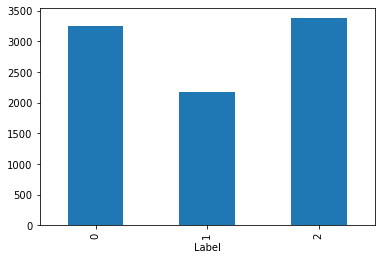

In [9]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(6,4))
df.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [10]:
# For entire dataset sentences for each labels 
df.Label.value_counts()

2    3375
0    3244
1    2174
Name: Label, dtype: int64

### Balanced Data

In [11]:
#balancing data 
from collections import Counter
import numpy as np
def balanceClasses(xs, ys):
    item = {}
    new_ys = []
    new_xs = []
    #"""Undersample xs, ys to balance classes."""
    freqs = Counter(ys)
    # the most common class  is the maximum number we want for all classes
    max_allowable = (freqs.most_common()[0][1])
    
    for val in freqs.most_common(): # List
        nums = np.random.randint(1000)
        i = 1
        item[val[0]] = max_allowable - val[1]
        
        if item[val[0]] > 0:            
            while(item[val[0]] - i != 0): 
                nums = nums + 1
                if ys[nums] == val[0]:
                    i += 1
                    new_ys.append(ys[nums])
                    new_xs.append(xs[nums])
    return new_xs, new_ys

In [12]:
new_text, new_label = balanceClasses(df['Text'], df['Label'])

In [13]:
data = pd.DataFrame(new_text)
data.columns = ['Text']
data['Label'] = new_label
data = pd.concat([df, data])

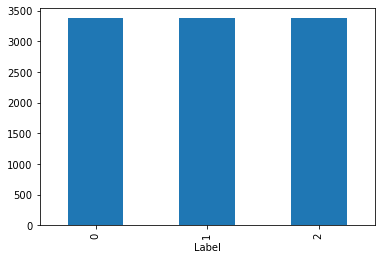

In [14]:
fig1 = plt.figure(figsize=(6,4))
data.groupby('Label').Text.count().plot.bar(ylim=0)
plt.show()

In [15]:
# For entire dataset sentences for each labels 
data.Label.value_counts()

2    3375
1    3374
0    3374
Name: Label, dtype: int64

In [16]:

data=data.sample(frac=1).reset_index(drop=True)
data

,Text,Label
0,'सुब्रमण्यम स्वामी का आरोप-सुशांत सिंह राजपूत ...,0
1,'@MAHTAB_RAZA_786 माशा अल्लाह,1
2,'BJP Mukth Bharath,0
3,'@OfficeOfDGP सटक गया राहत हुई जिहादी ही तो था...,2
4,'@lmaditya10 @rahatindori @AtharAamirKhan @dab...,2
...,...,...
10118,'@DeepikaSRajawat कॉन्ग्रेस की गोद में बैठे जि...,2
10119,'माशा अल्लाह,1
10120,'सुशांत सिंह राजपूत के साथ पालघर में संतों के ...,0
10121,'पाकिस्तान एक जेहादी आतंकवादी मुल्क है हर जेह...,2


### Data Preprocessing

In [17]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[,.\"\'!@#$%^&*(){}?/;`~:<>+=-]", "", text)
    return text

In [18]:
stopword=open("Devanagari/stopwords.txt","r")
stop_words=[]
# pre-process stopword
for i in stopword:
    i = re.sub('[\n]', '', i)
    stop_words.append(i)
hin_stopwords = set(stop_words) 

In [19]:
def CleanTokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            line = clean_text(line)
        else:
            continue      
        # tokenize the text
        tokens = word_tokenize(line)
        # remove puntuations
        table = str.maketrans('', '', string.punctuation)
        stripped = [w.translate(table) for w in tokens]
        # remove stop words
        words = [w for w in stripped if not w in hin_stopwords]
        tweets.append(words)
    return tweets

def Tokenize(df):
    tweets = list()
    lines = data["Text"].values.tolist()
    
    for line in lines:
        if isinstance(line, str):
            # tokenize the text
            tokens = word_tokenize(line)
        else:
            continue

        tweets.append(tokens)
    return tweets

tweets = CleanTokenize(data)


(-0.5, 499.5, 299.5, -0.5)

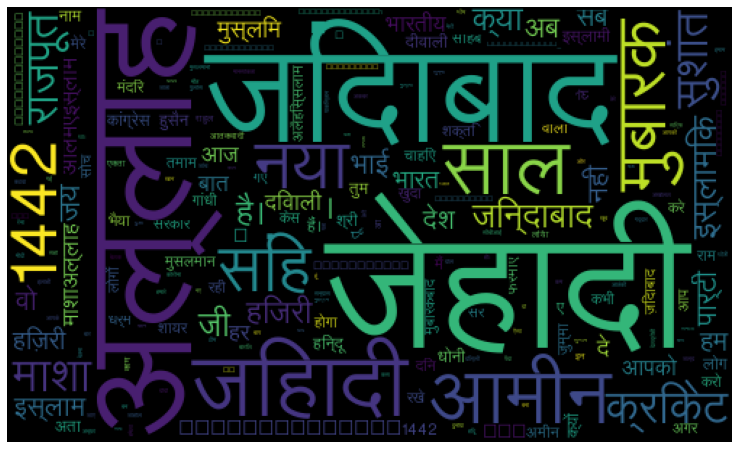

In [20]:
from collections import Counter
from wordcloud import WordCloud, STOPWORDS
from wordcloud import WordCloud, ImageColorGenerator


pos_data = data.loc[data['Label'] == 1]
pos_head_lines = Tokenize(pos_data)
#pos_head_lines = tweets
pos_lines = [j for sub in pos_head_lines for j in sub] 
pos_lines = [clean_text(w) for w in pos_lines if not w in hin_stopwords]
word_could_dict=Counter(pos_lines)
# text = ''
# for m in pos_lines:
#     text = text + m + ' '

wordcloud = WordCloud(font_path='Devanagari/Lohit-Devanagari.ttf',width = 500, height = 300, stopwords = hin_stopwords).generate_from_frequencies(word_could_dict)
plt.figure(figsize=(15,8))
plt.imshow(wordcloud)
plt.axis("off")

### Splitting data

In [21]:
validation_split = 0.1
max_length = 25


tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(tweets)
sequences = tokenizer_obj.texts_to_sequences(tweets)

word_index = tokenizer_obj.word_index
print("unique tokens - ",len(word_index))
vocab_size = len(tokenizer_obj.word_index) + 1
print('vocab size -', vocab_size)

lines_pad = pad_sequences(sequences, maxlen=max_length, padding='post')
sentiment =  data['Label'].values

indices = np.arange(lines_pad.shape[0])
np.random.shuffle(indices)
lines_pad = lines_pad[indices]
sentiment = sentiment[indices]

le = LabelEncoder()
sentiment = le.fit_transform(sentiment)
# transfor from a array to a vector
sentiment = sentiment.reshape(-1,1)


num_validation_samples = int(validation_split * lines_pad.shape[0])

X_train_pad = lines_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]

X_test_pad = lines_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)


unique tokens -  20358
vocab size - 20359


In [22]:
print('Shape of X_train_pad:', X_train_pad.shape)
print('Shape of y_train:', y_train.shape)

print('Shape of X_test_pad:', X_test_pad.shape)
print('Shape of y_test:', y_test.shape)

Shape of X_train_pad: (9111, 25)
Shape of y_train: (9111, 3)
Shape of X_test_pad: (1012, 25)
Shape of y_test: (1012, 3)


### Word2vec Word Embedding

In [23]:
from gensim import models
word2vec_path = 'GoogleNews-vectors-negative300.bin'
word2vec = models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [24]:
embedding_dim = 300

embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_matrix[i,:] = word2vec[word] if word in word2vec else np.random.rand(embedding_dim)
print()

In [25]:
embedding_layer = Embedding(len(word_index) + 1,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)

## LSTM Model

In [26]:
def createModel(embedding_layer):
    model = Sequential()
    model.add(embedding_layer)
    model.add(LSTM(256, dropout=0.2, recurrent_dropout=0.50))
    model.add(Dense(3, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer = keras.optimizers.RMSprop(learning_rate=1e-3), metrics=['acc'])
    return model

model = createModel(embedding_layer)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 25, 300)           6107700   
_________________________________________________________________
lstm (LSTM)                  (None, 256)               570368    
_________________________________________________________________
dense (Dense)                (None, 3)                 771       
Total params: 6,678,839
Trainable params: 571,139
Non-trainable params: 6,107,700
_________________________________________________________________


In [27]:
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=2)

Epoch 1/6
285/285 - 27s - loss: 1.0453 - acc: 0.4669 - val_loss: 1.2015 - val_acc: 0.4565
Epoch 2/6
285/285 - 26s - loss: 0.6784 - acc: 0.7201 - val_loss: 0.3922 - val_acc: 0.8370
Epoch 3/6
285/285 - 26s - loss: 0.4347 - acc: 0.8279 - val_loss: 0.3455 - val_acc: 0.8735
Epoch 4/6
285/285 - 26s - loss: 0.3588 - acc: 0.8598 - val_loss: 0.2888 - val_acc: 0.8824
Epoch 5/6
285/285 - 26s - loss: 0.3129 - acc: 0.8744 - val_loss: 0.2766 - val_acc: 0.8933
Epoch 6/6
285/285 - 25s - loss: 0.2947 - acc: 0.8834 - val_loss: 0.2730 - val_acc: 0.8962


In [28]:
results = model.evaluate(X_test_pad, y_test, batch_size=32)

32/32 [==============================] - 1s 21ms/step - loss: 0.2730 - acc: 0.8962


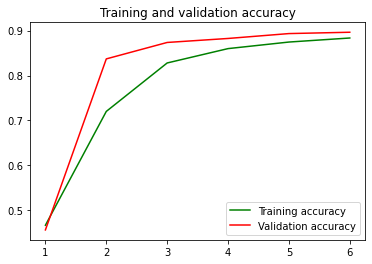

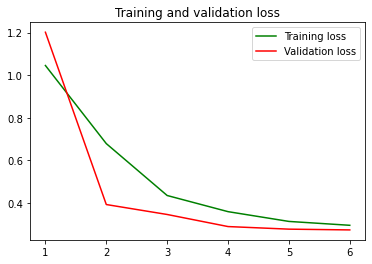

In [29]:
# Plot results
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

### 10 Fold cross validation

In [30]:
import random
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score 
from sklearn.model_selection import KFold
# KFold cross-validation
kFold = 10
scores = []
validation_split = 0.1
max_length = 25
results = []
train_results = []
print("LSTM with Word2Vec: ")
for i in range(kFold):
    print("Fold: ", i+1)
    prediction_val = []
    Y_test = []
    scores=[]
    random_shuff = random.randint(1, 7000)
    X_train_pad, X_test_pad, y_train, y_test = train_test_split(lines_pad, to_categorical(sentiment), test_size=0.10, shuffle = True, random_state=random_shuff)
    model = createModel(embedding_layer)
    history = model.fit(X_train_pad, y_train, batch_size=32, epochs=6, validation_data=(X_test_pad, y_test), verbose=1)
    
    print("Results for current fold:")
    print("Evaluation using training data")
    train_results.append(model.evaluate(X_train_pad, y_train, batch_size=128))
    print("Evaluation using testing data")
    results.append(model.evaluate(X_test_pad, y_test, batch_size=128))
    
    y_pred = model.predict(X_test_pad)
    for p in y_pred:
        prediction_val.append(np.argmax(p))
    for t in y_test:
        Y_test.append(np.argmax(t))
    scoreValue = accuracy_score(Y_test,prediction_val)
    scores.append(scoreValue)



LSTM with Word2Vec: 
Fold:  1
Epoch 1/6
285/285 [==============================] - 26s 93ms/step - loss: 1.0473 - acc: 0.4525 - val_loss: 1.0547 - val_acc: 0.4501
Epoch 2/6
285/285 [==============================] - 26s 91ms/step - loss: 0.6937 - acc: 0.7080 - val_loss: 0.3970 - val_acc: 0.8470
Epoch 3/6
285/285 [==============================] - 26s 91ms/step - loss: 0.4402 - acc: 0.8303 - val_loss: 0.6415 - val_acc: 0.7759
Epoch 4/6
285/285 [==============================] - 26s 90ms/step - loss: 0.3663 - acc: 0.8559 - val_loss: 0.4717 - val_acc: 0.8184
Epoch 5/6
285/285 [==============================] - 26s 90ms/step - loss: 0.3342 - acc: 0.8665 - val_loss: 0.2991 - val_acc: 0.8628
Epoch 6/6
285/285 [==============================] - 26s 90ms/step - loss: 0.3011 - acc: 0.8797 - val_loss: 0.3219 - val_acc: 0.8598
Results for current fold:
Evaluation using training data
72/72 [==============================] - 4s 56ms/step - loss: 0.2855 - acc: 0.8766
Evaluation using testing data
8/

In [31]:
import statistics 

score = []
for i in results:
    score.append(i[1])
x = statistics.mean(score)
    
print("Kfold Mean: ", x)

Kfold Mean:  0.8778874635696411


### Confusion matrix

In [32]:
#for last fold
results2 = confusion_matrix(Y_test,prediction_val)
print ('Confusion Matrix :')
print(results2) 
print ('Accuracy Score :',accuracy_score(Y_test,prediction_val))
print ('Report : ')
print (classification_report(Y_test,prediction_val))

Confusion Matrix :
[[306   9  31]
 [ 43 246  55]
 [ 17   0 306]]
Accuracy Score : 0.8469891411648569
Report : 
              precision    recall  f1-score   support

           0       0.84      0.88      0.86       346
           1       0.96      0.72      0.82       344
           2       0.78      0.95      0.86       323

    accuracy                           0.85      1013
   macro avg       0.86      0.85      0.85      1013
weighted avg       0.86      0.85      0.85      1013

